# Анализ тарифов компании "Мегалайн"

## Получение и изучение данных

### Поставленная задача и исходные данные

Заказчик проекта - федеральный оператор сотовой связи компания «Мегалайн».

Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

В распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год.

Задача: выполнить предварительный анализ поведения клиентов на небольшой выборке и сделать вывод — какой тариф лучше.

**Описание тарифов**

Тариф «Смарт»:
1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
    - минута разговора: 3 рубля
    - сообщение: 3 рубля
    - 1 Гб интернет-трафика: 200 рублей
    
Тариф «Ультра»:
1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
    - минута разговора: 1 рубль
    - сообщение: 1 рубль
    - 1 Гб интернет-трафика: 150 рублей

**Примечание:**

*«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.*

*Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.*

**Описание данных**

Таблица <ins>**users**</ins> (информация о пользователях):
- `user_id` — уникальный идентификатор пользователя
- `first_name` — имя пользователя
- `last_name` — фамилия пользователя
- `age` — возраст пользователя (годы)
- `reg_date` — дата подключения тарифа (день, месяц, год)
- `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- `city` — город проживания пользователя
- `tariff` — название тарифного плана

Таблица <ins>**calls**</ins> (информация о звонках):
- `id` — уникальный номер звонка
- `call_date` — дата звонка
- `duration` — длительность звонка в минутах
- `user_id` — идентификатор пользователя, сделавшего звонок

Таблица <ins>**messages**</ins> (информация о сообщениях):
- `id` — уникальный номер сообщения
- `message_date` — дата сообщения
- `user_id` — идентификатор пользователя, отправившего сообщение

Таблица <ins>**internet**</ins> (информация об интернет-сессиях):
- `id` — уникальный номер сессии
- `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
- `session_date` — дата интернет-сессии
- `user_id` — идентификатор пользователя

Таблица <ins>**tariffs**</ins> (информация о тарифах):
- `tariff_name` — название тарифа
- `rub_monthly_fee` — ежемесячная абонентская плата в рублях
- `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
- `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
- `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
- `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

### Обзор данных

<ins>Импорт библиотек</ins>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy import stats as st
pd.set_option('display.max_columns', None)

<ins>Открытие файлов с данными</ins>

In [2]:
users = pd.read_csv('https://code.s3.yandex.net/datasets/megaline_tariff_users.csv')
calls = pd.read_csv('https://code.s3.yandex.net/datasets/megaline_tariff_calls.csv')
messages = pd.read_csv('https://code.s3.yandex.net/datasets/megaline_tariff_messages.csv')
internet = pd.read_csv('https://code.s3.yandex.net/datasets/megaline_tariff_internet.csv')
tariffs = pd.read_csv('https://code.s3.yandex.net/datasets/megaline_tariff_tariffs.csv')

<ins>Изучение общей информации о данных</ins>

**Примечание:**
- при анализе методами .head() и .describe() не выявлено ничего критичного на этой стадии, поэтому в коде данного раздела они не приведены.

P.s. Однако, в следующих шагах метод head() активно используется. 

Таблица **users**

In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Наблюдения:
- `churn_date` (дата прекращения пользования тарифом) тип `object` - для корректного анализа необходимо поменять тип на `datetime64`, замена типа следует из наименования столбца, есть пропуски значений, однако в исходных данных указано - если значение пропущено, то тариф ещё действовал на момент выгрузки данных
- `reg_date` (дата подключения тарифа) тип `object` - для корректного анализа необходимо поменять тип на `datetime64`, замена типа следует из наименования столбца

Таблица **calls**

In [4]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Наблюдения:
- `call_date` (дата звонка) тип `object` - для корректного анализа необходимо поменять тип на `datetime64`, замена типа следует из наименования столбца

Таблица **messages**

In [5]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Наблюдения:
- `message_date` (дата сообщения) тип `object` - для корректного анализа необходимо поменять тип на `datetime64`, замена типа следует из наименования столбца

Таблица **internet**

In [6]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


Наблюдения:
- `session_date` (дата интернет-сессии) тип `object` - для корректного анализа необходимо поменять тип на `datetime64`, замена типа следует из наименования столбца
- столбца `Unnamed: 0` не было в исходных данных

Таблица **tariffs**

<ins>Получение общей информации о данных</ins>

In [7]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


Наблюдения:
- не выявлено ничего критичного. 

## Подготовка данных

### Приведение данных к нужным типам

Таблица **users**:
- `churn_date` (дата прекращения пользования тарифом), `reg_date` (дата подключения тарифа) тип `object` - необходимо поменять тип на `datetime64`

Таблица **calls**:
- `call_date` (дата звонка) тип `object` - необходимо поменять тип на `datetime64`

Таблица **messages**
- `message_date` (дата сообщения) тип `object` - необходимо поменять тип на `datetime64`

Таблица **internet**
- `session_date` (дата интернет-сессии) тип `object` - необходимо поменять тип на `datetime64`

In [8]:
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

### Поиск и исправление ошибок в данных

Из анализа методом .info() было видно, в таблице **users** в столбце `churn_date` (дата прекращения пользования тарифом) есть пропуски значений, однако в исходных данных указано - если значение пропущено, то тариф ещё действовал на момент выгрузки данных. Пропуски оставляем без изменений.

Из анализа методом .info() было видно, в таблице **internet** столбца `Unnamed: 0` не было в исходных данных. Далее примем решение, что с ним делать.

Выведем несколько строк из каждой таблицы на экран:

In [9]:
users.head(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaT,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaT,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaT,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaT,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaT,Пермь,Василиса,Блинова,2018-03-22,smart


В **users** при анализе данным методом ошибок не выявлено, кроме пропусков о которых сказано выше.

In [10]:
calls.head(10)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


В **calls** при анализе данным методом выявлено следующее.
- В столбце `duration` имеются нулевые значения, о которых в исходных данных сказано: "в данных вы найдёте звонки с нулевой продолжительностью. Это не ошибка: нулями обозначены пропущенные звонки, поэтому их не нужно удалять". Следовательно, оставляем без изменений.
- Минуты в столбце `duration` представлены до второго знака после запятой. В исходных данных на этот счёт сказано: "«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута." Необходимо применить округление до целых в большую сторону.

Округлим значения в столбце `duration` до целых в большую сторону.

In [11]:
calls['duration'] = np.ceil(calls['duration'])
calls.head(4)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.0,1000
1,1000_1,2018-08-17,0.0,1000
2,1000_2,2018-06-11,3.0,1000
3,1000_3,2018-09-21,14.0,1000


Иных ошибок в **calls** при анализе данным методом ошибок не выявлено.

In [12]:
messages.head(20)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


В **messages** при анализе данным методом ошибок не выявлено.

In [13]:
internet.head(20)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


В **internet** при анализе данным методом виден столбец, не указанный в описании данных `Unnamed: 0`, повторяющий индексы. Для анализа он не нужен. Удалим его:

In [14]:
internet.drop(columns = ['Unnamed: 0'], axis = 1, inplace=True)

In [15]:
internet.head(1)

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000


Также в **internet** обнаружено следующее.
- Мегабайты в столбце `mb_used` представлены до второго знака после запятой. В исходных данных на этот счёт сказано: "«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта." На данном этапе оставим значения в этом столбце без изменений.

Иных ошибок в **internet** не обнаружено.

In [16]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


В таблице **tariffs** в столбце `mb_per_month_included` указан объем интернет-трафика, включённого в абонентскую плату в мегабайтах, однако в описании тарифов он указан в гигабайтах, а также в столбце `rub_per_gb ` указаны значения в гигабайтах. Для удобства дальнейших расчётов переведём значения в столбце `mb_per_month_included` в гигабайты.

In [17]:
tariffs['mb_per_month_included'] = tariffs['mb_per_month_included']/1024

Для порядка переименуем столбец `mb_per_month_included` на `gb_per_month_included`.

In [18]:
tariffs = tariffs.rename(columns={'mb_per_month_included':'gb_per_month_included'})

In [19]:
tariffs.head()

,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15.0,500,550,200,3,3,smart
1,1000,30.0,3000,1950,150,1,1,ultra


Иных ошибок в **tariffs** при анализе данным методом ошибок не выявлено.

Проверим четыре первых таблицы на наличие явных дубликатов. В пятой - очевидно их нет.

In [20]:
users.duplicated().sum()
calls.duplicated().sum()
messages.duplicated().sum()
internet.duplicated().sum()
print (f'Количество дубликатов в таблице users: {users.duplicated().sum()}')
print (f'Количество дубликатов в таблице calls: {calls.duplicated().sum()}')
print (f'Количество дубликатов в таблице messages: {messages.duplicated().sum()}')
print (f'Количество дубликатов в таблице internet: {internet.duplicated().sum()}')

Количество дубликатов в таблице users: 0
Количество дубликатов в таблице calls: 0
Количество дубликатов в таблице messages: 0
Количество дубликатов в таблице internet: 0


Ошибки найдены и исправлены.

### Расчёты для каждого пользователя

####  <ins>**Расчёт кол-ва сделанных звонков и израсходованных минут разговора по месяцам для каждого пользователя**</ins>

Добавим столбец `month` (месяц) в таблицу **calls**, значения для данного столбца получим из значений столбца `call_date` (дата звонка):

In [21]:
calls['month'] = calls['call_date'].dt.month
calls.head(1)

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.0,1000,7


Создадим новую таблицу <ins>**calls_min_month**</ins> с информацией о кол-ве сделанных звонков и израсходованных минут разговора по месяцам для каждого пользователя.

In [22]:
calls_min_month = (
                  calls.pivot_table(index=['user_id','month'],
                  aggfunc={'id':'count','duration':'sum'})
                  .rename(columns={'id': 'month_calls', 'duration': 'month_duration'}).fillna(0)
                  )
calls_min_month.head(3)

month_duration  month_calls
user_id month                             
1000    5               159.0           22
        6               172.0           43
        7               340.0           47

Красиво, но для удобства дальнейшей работы с данными сбросим индексы:

In [23]:
calls_min_month = calls_min_month.reset_index()
calls_min_month.head(3)

,user_id,month,month_duration,month_calls
0,1000,5,159.0,22
1,1000,6,172.0,43
2,1000,7,340.0,47


Создана новая таблица <ins>**calls_min_month**</ins> с информацией о кол-ве сделанных звонков и израсходованных минут разговора по месяцам для каждого пользователя:
- `user_id` — идентификатор пользователя, сделавшего звонок
- `month` - месяц
- `month_duration` — израсходованные минуты разговора в месяц
- `month_calls` - кол-во сделанных звонков в месяц

#### <ins>**Расчёт кол-ва отправленных сообщений по месяцам для каждого пользователя**</ins>

Добавим столбец `month` (месяц) в таблицу **messages**, значения для данного столбца получим из значений столбца `message_date ` (дата сообщения):

In [24]:
messages['month'] = messages['message_date'].dt.month
messages.head(1)

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6


Создадим новую таблицу <ins>**messages_month**</ins> с информацией о кол-ве отправленных сообщений по месяцам для каждого пользователя.

In [25]:
messages_month = (
                  messages.pivot_table(index=['user_id','month'],
                  aggfunc={'id':'count'})
                  .rename(columns={'id': 'month_messages'})
                 ).fillna(0).reset_index()
messages_month.head()

,user_id,month,month_messages
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


Создана новая таблица <ins>**messages_month**</ins> с информацией о кол-ве отправленных сообщений по месяцам для каждого пользователя:
- `user_id` — идентификатор пользователя, отправившего сообщение
- `month` - месяц
- `month_messages` - кол-во отправленных сообщений в месяц

#### <ins>**Расчёт объема израсходованного интернет-трафика по месяцам для каждого пользователя**</ins>

Добавим столбец `month` (месяц) в таблицу **internet**, значения для данного столбца получим из значений столбца `session_date ` (дата интернет-сессии):

In [26]:
internet['month'] = internet['session_date'].dt.month
internet.head(3)

,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,11
1,1000_1,1052.81,2018-09-07,1000,9
2,1000_2,1197.26,2018-06-25,1000,6


Создадим новую таблицу <ins>**internet_month**</ins> с информацией об объеме израсходованного интернет-трафика по месяцам для каждого пользователя.

In [27]:
internet_month = (
                  internet.pivot_table(index=['user_id','month'],
                  aggfunc={'mb_used':'sum'})
                  .rename(columns={'mb_used': 'month_mb_used'})
                 ).fillna(0).reset_index()
internet_month.head(3)

,user_id,month,month_mb_used
0,1000,5,2253.49
1,1000,6,23233.77
2,1000,7,14003.64


Мегабайты в столбце `month_mb_used` представлены до второго знака после запятой. В исходных данных на этот счёт сказано: "«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта."

Переведём значения в столбце `month_mb_used` из мегабайт и гигабайты и округлим  до целых в большую сторону.

In [28]:
internet_month['month_mb_used'] = np.ceil(internet_month['month_mb_used']/1024)

Для порядка переименуем столбец `month_mb_used` в `month_gb_used`.

In [29]:
internet_month = internet_month.rename(columns={'month_mb_used': 'month_gb_used'})

In [30]:
internet_month.head(3)

,user_id,month,month_gb_used
0,1000,5,3.0
1,1000,6,23.0
2,1000,7,14.0


Создана новая таблица <ins>**internet_month**</ins> с информацией об объеме израсходованного интернет-трафика по месяцам для каждого пользователя:
- `user_id` — идентификатор пользователя, сделавшего звонок
- `month` - месяц
- `month_gb_used` - объеме израсходованного интернет-трафика по месяцам (Гб)

#### <ins>**Расчёт помесячной выручки с каждого пользователя**</ins>

Создадим новую таблицу <ins>**revenue_month**</ins> с информацией о помесячную выручке с каждого пользователя.

Для наглядности хода мыслей разобьём задачу на несколько этапов

Cоздадим таблицу **traffic_month**, к которой потом добавим необходимые данные из других таблиц,

в ней объединим таблицы
- **internet_month**,
- **calls_min_month**,
- **messages_month**

по столбцам `user_id` и `month` с типом слияния `outer ` (объединение данных).

In [31]:
traffic_month=(
              internet_month.merge(calls_min_month, on=['user_id','month'], how='outer')
              .merge(messages_month, on=['user_id','month'], how='outer').fillna(0)
              )
traffic_month.head(3)

,user_id,month,month_gb_used,month_duration,month_calls,month_messages
0,1000,5,3.0,159.0,22.0,22.0
1,1000,6,23.0,172.0,43.0,60.0
2,1000,7,14.0,340.0,47.0,75.0


Выделим в отдельную таблицу <ins>**users_tariff**</ins> следующие данные:
- `user_id` — уникальный идентификатор пользователя
- `tariff` — название тарифного плана
- `city` - город (данный столбец понадобится позже при проверке гипотез)

In [32]:
users_tariff = users[['user_id','tariff', 'city']]

Переименуем в таблице **tariffs** столбец `tariff_name` в `tariff` для возможности объединения по данному столбцу с таблицей **users_tariff**.

In [33]:
tariffs = tariffs.rename(columns={'tariff_name':'tariff'})

Объединим таблицы **users_tariff** и **tariffs** в таблицу **users_revenue** по столбцу `tariff` с типом слияния `outer ` (объединение данных):

In [34]:
users_revenue = users_tariff.merge(tariffs, on='tariff', how='outer')
users_revenue.head(3)

,user_id,tariff,city,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,ultra,Краснодар,1000,30.0,3000,1950,150,1,1
1,1003,ultra,Москва,1000,30.0,3000,1950,150,1,1
2,1004,ultra,Новокузнецк,1000,30.0,3000,1950,150,1,1


Объединим таблицы **traffic_month** и **users_revenue** в таблицу <ins>**revenue_month_sup**</ins> (sup - означает support, вспомогательная таблица для вычислений)
- по столбцу `user_id` с типом слияния `outer ` (объединение данных),
- заменив все пропуски нулями, так как пропуски означают, что траффика (разговоров, смс, интернета) не было, и замена на ноль логична,
- отсортировав по столбцу `user_id`,
- перезаписав индексы.

In [35]:
revenue_month_sup = (
                     users_revenue.merge(traffic_month, on='user_id', how='outer')
                     .sort_values(by='user_id')
                     .reset_index(drop=True)
                     .fillna(0)
                    )
revenue_month_sup.head(10)

,user_id,tariff,city,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,month,month_gb_used,month_duration,month_calls,month_messages
0,1000,ultra,Краснодар,1000,30.0,3000,1950,150,1,1,5.0,3.0,159.0,22.0,22.0
1,1000,ultra,Краснодар,1000,30.0,3000,1950,150,1,1,6.0,23.0,172.0,43.0,60.0
2,1000,ultra,Краснодар,1000,30.0,3000,1950,150,1,1,7.0,14.0,340.0,47.0,75.0
3,1000,ultra,Краснодар,1000,30.0,3000,1950,150,1,1,8.0,14.0,408.0,52.0,81.0
4,1000,ultra,Краснодар,1000,30.0,3000,1950,150,1,1,9.0,15.0,466.0,58.0,57.0
5,1000,ultra,Краснодар,1000,30.0,3000,1950,150,1,1,10.0,15.0,350.0,57.0,73.0
6,1000,ultra,Краснодар,1000,30.0,3000,1950,150,1,1,11.0,15.0,338.0,43.0,58.0
7,1000,ultra,Краснодар,1000,30.0,3000,1950,150,1,1,12.0,10.0,333.0,46.0,70.0
8,1001,smart,Москва,50,15.0,500,550,200,3,3,12.0,14.0,414.0,63.0,0.0
9,1001,smart,Москва,50,15.0,500,550,200,3,3,11.0,18.0,430.0,59.0,0.0


В таблице **revenue_month_sup** создадим новые столбцы `revenue_minutes`, `revenue_messages`, `revenue_gb_used` (превышение бесплатного лимита на звонки, сообщения, интернет-траффик соответственно):
- `revenue_minutes`: из суммарного количества минут разговора в месяц `month_duration` вычтем бесплатный лимит `minutes_included`
- `revenue_messages`: из суммарного количества сообщений в месяц `month_messages` вычтем бесплатный лимит `messages_included`
- `revenue_gb_used`: из суммарного количества мнтернет-трафика в месяц `month_gb_used` вычтем бесплатный лимит `gb_per_month_included`.

В случае если превышения нет, то принимаем значение ноль.

Результаты вычислений умножим на значение из тарифного плана (`rub_per_minute`, `rub_per_message`, `rub_per_gb` соответственно).

*Примечание. За неимением информации в исходных данных примем, что неиспользованные за предыдущий месяц звонки, смс, интернет на следующий месяц не переносятся. Представим, что нам это подтвердил заказчик при обращении.*

In [36]:
def above_limit(revenue_df, new_col, traf, inc, plan):    
    revenue_df[new_col] = (revenue_df[traf] - revenue_df[inc])*revenue_df[plan]    
    revenue_df.loc[revenue_df[new_col] < 0, new_col] = 0
    return revenue_df.head(3)
above_limit(revenue_month_sup, 'revenue_minutes', 'month_duration', 'minutes_included', 'rub_per_minute')
above_limit(revenue_month_sup, 'revenue_messages', 'month_messages', 'messages_included', 'rub_per_message')
above_limit(revenue_month_sup, 'revenue_gb_used', 'month_gb_used', 'gb_per_month_included', 'rub_per_gb')

,user_id,tariff,city,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,month,month_gb_used,month_duration,month_calls,month_messages,revenue_minutes,revenue_messages,revenue_gb_used
0,1000,ultra,Краснодар,1000,30.0,3000,1950,150,1,1,5.0,3.0,159.0,22.0,22.0,0.0,0.0,0.0
1,1000,ultra,Краснодар,1000,30.0,3000,1950,150,1,1,6.0,23.0,172.0,43.0,60.0,0.0,0.0,0.0
2,1000,ultra,Краснодар,1000,30.0,3000,1950,150,1,1,7.0,14.0,340.0,47.0,75.0,0.0,0.0,0.0


Сложим значения в столбцах `revenue_minutes`, `revenue_messages`, `revenue_gb_used` между собой и прибавим абонентскую плату `rub_monthly_fee`, соответствующую тарифному плану. Результаты сохраним в новый столбец `revenue`.

In [37]:
revenue_month_sup['revenue'] = (
        revenue_month_sup['revenue_minutes']+
        revenue_month_sup['revenue_messages']+
        revenue_month_sup['revenue_gb_used']+
        revenue_month_sup['rub_monthly_fee'])

In [38]:
revenue_month_sup.head(20)

,user_id,tariff,city,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,month,month_gb_used,month_duration,month_calls,month_messages,revenue_minutes,revenue_messages,revenue_gb_used,revenue
0,1000,ultra,Краснодар,1000,30.0,3000,1950,150,1,1,5.0,3.0,159.0,22.0,22.0,0.0,0.0,0.0,1950.0
1,1000,ultra,Краснодар,1000,30.0,3000,1950,150,1,1,6.0,23.0,172.0,43.0,60.0,0.0,0.0,0.0,1950.0
2,1000,ultra,Краснодар,1000,30.0,3000,1950,150,1,1,7.0,14.0,340.0,47.0,75.0,0.0,0.0,0.0,1950.0
3,1000,ultra,Краснодар,1000,30.0,3000,1950,150,1,1,8.0,14.0,408.0,52.0,81.0,0.0,0.0,0.0,1950.0
4,1000,ultra,Краснодар,1000,30.0,3000,1950,150,1,1,9.0,15.0,466.0,58.0,57.0,0.0,0.0,0.0,1950.0
5,1000,ultra,Краснодар,1000,30.0,3000,1950,150,1,1,10.0,15.0,350.0,57.0,73.0,0.0,0.0,0.0,1950.0
6,1000,ultra,Краснодар,1000,30.0,3000,1950,150,1,1,11.0,15.0,338.0,43.0,58.0,0.0,0.0,0.0,1950.0
7,1000,ultra,Краснодар,1000,30.0,3000,1950,150,1,1,12.0,10.0,333.0,46.0,70.0,0.0,0.0,0.0,1950.0
8,1001,smart,Москва,50,15.0,500,550,200,3,3,12.0,14.0,414.0,63.0,0.0,0.0,0.0,0.0,550.0
9,1001,smart,Москва,50,15.0,500,550,200,3,3,11.0,18.0,430.0,59.0,0.0,0.0,0.0,600.0,1150.0


Создадим новую таблицу <ins>**revenue_month**</ins> с информацией о помесячную выручке с каждого пользователя.

In [39]:
revenue_month = revenue_month_sup.loc[:,['user_id','month','revenue']]
revenue_month.head(10)

,user_id,month,revenue
0,1000,5.0,1950.0
1,1000,6.0,1950.0
2,1000,7.0,1950.0
3,1000,8.0,1950.0
4,1000,9.0,1950.0
5,1000,10.0,1950.0
6,1000,11.0,1950.0
7,1000,12.0,1950.0
8,1001,12.0,550.0
9,1001,11.0,1150.0


Таблица <ins>**revenue_month**</ins>:
- `user_id` — уникальный идентификатор пользователя
- `month` - месяц
- `revenue` - помесячная выручка с пользователя

Помесячная выручка с каждого пользователя посчитана в новой таблице <ins>**revenue_month**</ins> в столбце `revenue`.

## Анализ данных

*Примечание. Ранее была создана таблица <ins>**revenue_month_sup**</ins>, откуда можно было делать срезы столбцов, однако есть риск подхватить пропущенные значения, поэтому ниже формируются отдельные таблицы без NaN. Таблицей <ins>**revenue_month_sup**</ins> осознанно не пользуемся.*

### Минуты разговора, требуемые пользователям каждого тарифа в месяц.

Объединим таблицы **calls_min_month** и **users_tariff** в таблицу **user_duration** по столбцу `user_id` с типом слияния `left` (попадут все значения левого датафрейма):

In [40]:
user_duration = calls_min_month.merge(users_tariff, on='user_id', how='left')
user_duration.head(3)

,user_id,month,month_duration,month_calls,tariff,city
0,1000,5,159.0,22,ultra,Краснодар
1,1000,6,172.0,43,ultra,Краснодар
2,1000,7,340.0,47,ultra,Краснодар


Посчитаем среднее, дисперсию, стандартное отклонение и медиану
- минут разговора пользователей для каждого тарифа в месяц - значения в столбцах `month_duration` в новой таблице <ins>**duration_stat**</ins>.

In [41]:
duration_stat = user_duration.pivot_table(index='tariff',
                                          values='month_duration',
                                          aggfunc = {'mean','var','std', 'median'}).reset_index()
duration_stat

,tariff,mean,median,std,var
0,smart,419.062978,423.0,189.325618,35844.189551
1,ultra,545.451104,528.0,306.925754,94203.418396


**Построим гистограммы**

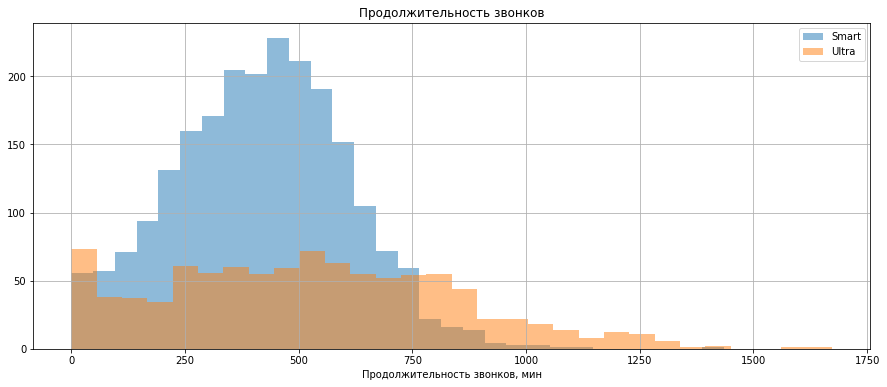

Среднее Smart: 418.0
Среднее Ultra: 526.0
Дисперсия Smart: 36265.12415310986
Дисперсия Ultra: 100950.00623331097
Стандартное отклонение Smart 190.43404147659592
Стандартное отклонение Ultra 317.72630711559117


In [42]:
plt.figure(figsize = (15,6))

revenue_month_sup.query('tariff == "smart"')['month_duration'].hist(bins = 30, alpha = .5)
revenue_month_sup.query('tariff == "ultra"')['month_duration'].hist(bins = 30, alpha = .5)

plt.title('Продолжительность звонков')
plt.legend(['Smart', 'Ultra'])
plt.xlabel('Продолжительность звонков, мин')
plt.show()

print('Среднее Smart:', np.round(revenue_month_sup.query('tariff == "smart"')['month_duration'].mean()))
print('Среднее Ultra:', np.round(revenue_month_sup.query('tariff == "ultra"')['month_duration'].mean()))
print('Дисперсия Smart:', np.var(revenue_month_sup.query('tariff == "smart"')['month_duration']))
print('Дисперсия Ultra:', np.var(revenue_month_sup.query('tariff == "ultra"')['month_duration']))
print('Стандартное отклонение Smart', np.std(revenue_month_sup.query('tariff == "smart"')['month_duration']))
print('Стандартное отклонение Ultra', np.std(revenue_month_sup.query('tariff == "ultra"')['month_duration']))

In [43]:
user_duration.sort_values(by='month_duration').head(10)

,user_id,month,month_duration,month_calls,tariff,city
1605,1257,7,0.0,1,ultra,Санкт-Петербург
1606,1257,8,0.0,2,ultra,Санкт-Петербург
1493,1240,2,0.0,2,ultra,Воронеж
1607,1257,9,0.0,1,ultra,Санкт-Петербург
2318,1373,1,0.0,2,smart,Улан-Удэ
2321,1373,4,0.0,1,smart,Улан-Удэ
327,1053,9,1.0,2,ultra,Ростов-на-Дону
2690,1424,6,1.0,1,ultra,Москва
2319,1373,2,2.0,1,smart,Улан-Удэ
2350,1376,5,2.0,1,smart,Самара


Опишем распределения.

Тариф `smart`:
- датасет близок к нормальному распределению данных, есть незначительная скошенность влево, это можно оценить и по расчитанным ранее значениям - медиана больше среднего.

Тариф `ultra`:
- датасет ассиметричен со скошенным вправо набором данных, это можно оценить и по расчитанным ранее значениям - медиана меньше среднего.

### Сообщения, требуемые пользователям каждого тарифа в месяц.

Объединим таблицы **messages_month** и **users_tariff** в таблицу **user_messages** по столбцу `user_id` с типом слияния `left` (попадут все значения левого датафрейма):

In [44]:
user_messages = messages_month.merge(users_tariff, on='user_id', how='left')
user_messages.head(3)

,user_id,month,month_messages,tariff,city
0,1000,5,22,ultra,Краснодар
1,1000,6,60,ultra,Краснодар
2,1000,7,75,ultra,Краснодар


Посчитаем среднее, дисперсию, стандартное отклонение и медиану
- сообщений пользователей для каждого тарифа в месяц - значения в столбцах `month_messages` в новой таблице <ins>**messages_stat**</ins>.

In [45]:
messages_stat = user_messages.pivot_table(index='tariff',
                                          values='month_messages',
                                          aggfunc = {'mean','var','std', 'median'}).reset_index()
messages_stat

,tariff,mean,median,std,var
0,smart,38.716441,34.0,26.787949,717.594201
1,ultra,61.161006,51.0,45.931026,2109.659183


**Построим гистограммы**

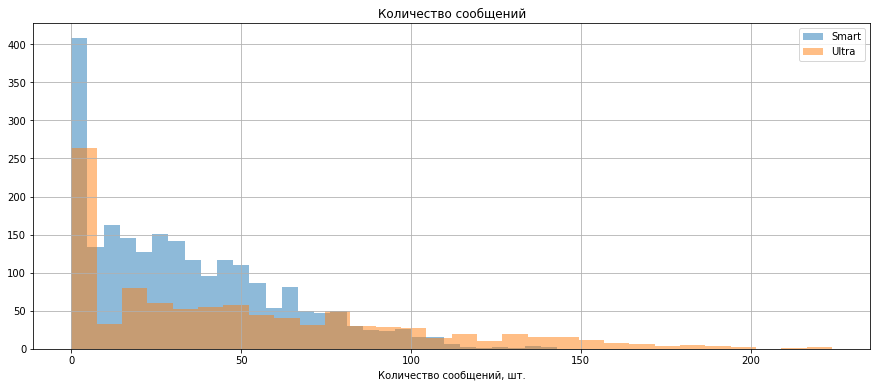

Среднее Smart: 33.0
Среднее Ultra: 49.0
Дисперсия Smart: 796.5978766916687
Дисперсия Ultra: 2283.099557085197
Стандартное отклонение Smart 28.224065559229214
Стандартное отклонение Ultra 47.78179106192229


In [46]:
plt.figure(figsize = (15,6))

revenue_month_sup.query('tariff == "smart"')['month_messages'].hist(bins = 30, alpha = .5)
revenue_month_sup.query('tariff == "ultra"')['month_messages'].hist(bins = 30, alpha = .5)

plt.title('Количество сообщений')
plt.legend(['Smart', 'Ultra'])
plt.xlabel('Количество сообщений, шт.')
plt.show()

print('Среднее Smart:', np.round(revenue_month_sup.query('tariff == "smart"')['month_messages'].mean()))
print('Среднее Ultra:', np.round(revenue_month_sup.query('tariff == "ultra"')['month_messages'].mean()))
print('Дисперсия Smart:', np.var(revenue_month_sup.query('tariff == "smart"')['month_messages']))
print('Дисперсия Ultra:', np.var(revenue_month_sup.query('tariff == "ultra"')['month_messages']))
print('Стандартное отклонение Smart', np.std(revenue_month_sup.query('tariff == "smart"')['month_messages']))
print('Стандартное отклонение Ultra', np.std(revenue_month_sup.query('tariff == "ultra"')['month_messages']))

Опишем распределения.

Тариф `smart`:
- датасет ассиметричен со скошенным вправо набором данных, это можно оценить и по расчитанным ранее значениям - медиана меньше среднего.

Тариф `ultra`:
- датасет ассиметричен со скошенным вправо набором данных, это можно оценить и по расчитанным ранее значениям - медиана меньше среднего.

### Объём интернет-трафика, требуемый пользователям каждого тарифа в месяц.

Объединим таблицы **internet_month** и **users_tariff** в таблицу **user_internet** по столбцу `user_id` с типом слияния `left` (попадут все значения левого датафрейма):

In [47]:
user_internet = internet_month.merge(users_tariff, on='user_id', how='left')
user_internet.head(3)

,user_id,month,month_gb_used,tariff,city
0,1000,5,3.0,ultra,Краснодар
1,1000,6,23.0,ultra,Краснодар
2,1000,7,14.0,ultra,Краснодар


Посчитаем среднее, дисперсию, стандартное отклонение и медиану
- объёма интернет-трафика пользователей для каждого тарифа в месяц - значения в столбцах `month_gb_used` в новой таблице <ins>**internet_stat**</ins>.

In [48]:
internet_stat = user_internet.pivot_table(index='tariff',
                                          values='month_gb_used',
                                          aggfunc = {'mean','var','std', 'median'}).reset_index()
internet_stat

,tariff,mean,median,std,var
0,smart,16.336176,17.0,5.737923,32.923756
1,ultra,19.694359,19.0,9.702924,94.146734


**Построим гистограммы**

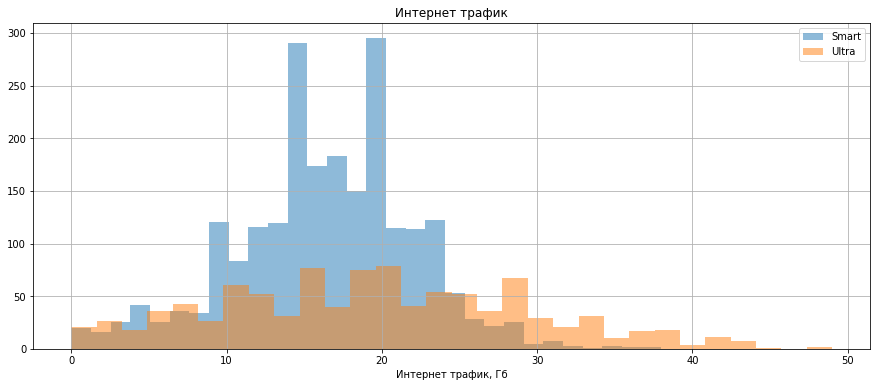

Среднее Smart: 16.0
Среднее Ultra: 19.0
Дисперсия Smart: 33.11859498481772
Дисперсия Ultra: 97.27978308900676
Стандартное отклонение Smart 5.754875757548352
Стандартное отклонение Ultra 9.863051408616238


In [49]:
plt.figure(figsize = (15,6))

revenue_month_sup.query('tariff == "smart"')['month_gb_used'].hist(bins = 30, alpha = .5)
revenue_month_sup.query('tariff == "ultra"')['month_gb_used'].hist(bins = 30, alpha = .5)

plt.title('Интернет трафик')
plt.legend(['Smart', 'Ultra'])
plt.xlabel('Интернет трафик, Гб')
plt.show()

print('Среднее Smart:', np.round(revenue_month_sup.query('tariff == "smart"')['month_gb_used'].mean()))
print('Среднее Ultra:', np.round(revenue_month_sup.query('tariff == "ultra"')['month_gb_used'].mean()))
print('Дисперсия Smart:', np.var(revenue_month_sup.query('tariff == "smart"')['month_gb_used']))
print('Дисперсия Ultra:', np.var(revenue_month_sup.query('tariff == "ultra"')['month_gb_used']))
print('Стандартное отклонение Smart', np.std(revenue_month_sup.query('tariff == "smart"')['month_gb_used']))
print('Стандартное отклонение Ultra', np.std(revenue_month_sup.query('tariff == "ultra"')['month_gb_used']))

Опишем распределения.

Тариф `smart`:
- датасет близок к нормальному распределению данных, есть незначительная скошенность влево, это можно оценить и по расчитанным ранее значениям - медиана чуть больше среднего.

Тариф `ultra`:
- датасет близок к нормальному распределению данных, есть незначительная скошенность вправо, это можно оценить и по расчитанным ранее значениям - медиана чуть меньше среднего.

<ins>Опишем поведение клиентов оператора, исходя из выборки.</ins>

Пользователям тарифа `smart` в месяц требуется:
- от 0 до 1000 минут разговора, в среднем 418 минут
- от 0 до 140 сообщений, в среднем 33
- от 0 до 40Гб интернета, в среднем 16Гб

Пользователям тарифа `ultra` в месяц требуется:
- от 0 до 1500 минут разговора, в среднем 526 минут
- от 0 до 200 сообщений, в среднем 49
- от 0 до 50Гб интернета, в среднем 19Гб

<ins>Отличия тарифов:</ins>
- пользователи тарифа `ultra` разговаривают больше, в среднем на 108 мин в месяц
- пользователи тарифа `ultra` пишут больше сообщений, в среднем на 16 шт в месяц
- пользователи тарифа `ultra` тратят больше интернета, в среднем на 4 Гб в месяц

## Проверка гипотез

### Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

Объединим таблицы **revenue_month** и **users_tariff** в таблицу **user_revenue** по столбцу `user_id` с типом слияния `left` (попадут все значения левого датафрейма):

In [50]:
user_revenue = revenue_month.merge(users_tariff, on='user_id', how='left')
user_revenue.head(3)

,user_id,month,revenue,tariff,city
0,1000,5.0,1950.0,ultra,Краснодар
1,1000,6.0,1950.0,ultra,Краснодар
2,1000,7.0,1950.0,ultra,Краснодар


Таблица <ins>**user_revenue**</ins>:
- `user_id` — уникальный идентификатор пользователя
- `month` - месяц
- `revenue` - помесячная выручка с пользователя
- `tariff` - тариф
- `city` - город

Для наглядности выделим данные в столбце `revenue` в отдельные подвыборки (`user_revenue_smart` и `user_revenue_ultra`) по тарифам.

In [51]:
user_revenue_smart = user_revenue.query('tariff == "smart"')['revenue']
user_revenue_ultra = user_revenue.query('tariff == "ultra"')['revenue']

<ins>**Нулевая гипотеза H₀:**</ins>
- Cредние выручки пользователей тарифов «Ультра» и «Смарт» равны.

Это гипотеза о равенстве средних двух генеральных совокупностей по взятым из них выборкам, независящих друг от друга.

<ins>**Альтернативная гипотеза H₁:**</ins>
- Cредние выручки пользователей тарифов «Ультра» и «Смарт» не равны.

Проверим дисперсии двух выборок

In [52]:
np.var(user_revenue_smart, ddof=1)

669730.763894807

In [53]:
np.var(user_revenue_ultra, ddof=1)

141387.7148093615

Проверим размер двух выборок

In [54]:
len(user_revenue_smart)

2230

In [55]:
len(user_revenue_ultra)

986

- Для проверки нулевой гипотезы применим метод `scipy.stats.ttest_ind()`.
- Видим, что дисперсии не равны, выборки разные по размеру, поэтому используем дополнительный параметр `equal_var = False`.
- Критический уровень статистической значимости примем 0,05 - стандартная величина, значение считаю достаточным, т.к. анализируем не судебные дела и не медицину.
- Если p-value окажется меньше уровня статистической значимости - отвегнем гипотезу.

In [56]:
alpha = .05

results = st.ttest_ind(
    user_revenue_smart, 
    user_revenue_ultra,
    equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.927011394420941e-250
Отвергаем нулевую гипотезу


Итог.
- Отвергаем нулевую гипотезу, т.к. вероятность получить наблюдаемый или еще более далекий от предполагаемого результат при условии, что нулевая гипотеза верна, ниже критического уровня статистической значимости, причём радикально.
- Принимаем, что средние выручки пользователей тарифов «Ультра» и «Смарт» не равны.

### Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Данное задание можно прочесть двояко:
- исследуем пользователей всех тарифов, однако это противоречит исходным данным от заказчика, где делается акцент на сравнение тарифов.
- исследуем пользователей с учётом тарифа

Отработаем два варианта на выбор заказчика.

Работаем с таблицей `user_revenue`. По исходным данным необходимо исследовать тарифы, поэтому в данном разделе будет проверятся гипотеза в рамках тарифов `smart` и `ultra`. Для наглядности выделим данные в столбце `revenue` в отдельные подвыборки (`moscow`,`moscow_smart`, `moscow_ultra` и `not_moscow`,`not_moscow_smart`, `not_moscow_ultra`) по принадлежности к Москве и не Москве.

In [57]:
moscow = user_revenue.query('city == "Москва"')['revenue']
not_moscow = user_revenue.query('city != "Москва"')['revenue']
moscow_smart = user_revenue.query('city == "Москва" and tariff == "smart"')['revenue']
moscow_ultra = user_revenue.query('city == "Москва" and tariff == "ultra"')['revenue']
not_moscow_smart = user_revenue.query('city != "Москва" and tariff == "smart"')['revenue']
not_moscow_ultra = user_revenue.query('city != "Москва" and tariff == "ultra"')['revenue']

#### Вариант 1. Гипотеза для всех тарифов

<ins>**Нулевая гипотеза H₀:**</ins>
- Cредние выручки пользователей из Москвы и из других регионов равны.

Это гипотеза о равенстве средних двух генеральных совокупностей по взятым из них выборкам, независящих друг от друга.

Парная выборка означает, что измеряется некоторая переменная дважды для одних и тех же единиц. В нашем примере это пара измерений выручки пользователей в рамках тарифа — из Москвы и не из Москвы.

<ins>**Альтернативная гипотеза H₁:**</ins>
- Cредние выручки пользователей из Москвы и из других регионов не равны.

Проверим дисперсии выборок

In [58]:
np.var(moscow, ddof=1)

565636.467011886

In [59]:
np.var(not_moscow, ddof=1)

654069.5749627769

Проверим размеры выборок

In [60]:
len(moscow)

611

In [61]:
len(not_moscow)

2605

- Для проверки нулевой гипотезы применим метод `scipy.stats.ttest_ind()`.
- Видим, что дисперсии близки, фактом, что выборки разные по размеру принебрежем, дополнительный параметр `equal_var` не задаём, т.к. считаем, что дисперсии равны.
- Критический уровень статистической значимости примем 0,05 - стандартная величина, значение считаю достаточным, т.к. анализируем не судебные дела и не медицину.
- Если p-value окажется меньше уровня статистической значимости - отвегнем гипотезу.

In [62]:
alpha = .05

results = st.ttest_ind(
                       moscow, 
                       not_moscow,
                       )

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5400751614511182
Не получилось отвергнуть нулевую гипотезу


Итог.
- Не получилось отвергнуть нулевую гипотезу, т.к. вероятность получить наблюдаемый или еще более далекий от предполагаемого результат при условии, что нулевая гипотеза верна, гораздо выше критического уровня статистической значимости.
- Принимаем, что средние выручки пользователей из Москвы и из других регионов равны.

#### Вариант 2. Гипотеза с учётом тарифа

<ins>Для каждого тарифа:</ins>

<ins>**Нулевая гипотеза H₀:**</ins>
- Cредние выручки пользователей из Москвы и из других регионов равны.

Это гипотеза о равенстве средних двух генеральных совокупностей по взятым из них выборкам, независящих друг от друга.

Парная выборка означает, что измеряется некоторая переменная дважды для одних и тех же единиц. В нашем примере это пара измерений выручки пользователей в рамках тарифа — из Москвы и не из Москвы.

<ins>**Альтернативная гипотеза H₁:**</ins>
- Cредние выручки пользователей из Москвы и из других регионов не равны.

Проверим дисперсии выборок

In [63]:
np.var(moscow_smart, ddof=1)

567691.7523719803

In [64]:
np.var(not_moscow_smart, ddof=1)

690769.5296911099

In [65]:
np.var(moscow_ultra, ddof=1)

122568.75

In [66]:
np.var(not_moscow_ultra, ddof=1)

147114.34919427347

Проверим размеры выборок

In [67]:
len(moscow_smart)

386

In [68]:
len(not_moscow_smart)

1844

In [69]:
len(moscow_ultra)

225

In [70]:
len(not_moscow_ultra)

761

- Для проверки нулевой гипотезы применим метод `scipy.stats.ttest_ind()`.
- Видим, что дисперсии не равны, выборки разные по размеру, поэтому используем дополнительный параметр `equal_var = False`.
- Критический уровень статистической значимости примем 0,05 - стандартная величина, значение считаю достаточным, т.к. анализируем не судебные дела и не медицину.
- Если p-value окажется меньше уровня статистической значимости - отвегнем гипотезу.

In [71]:
alpha = .05

results = st.ttest_ind(
                       moscow_smart, 
                       not_moscow_smart,
                       equal_var = False
                       )

print('p-значение для тарифа smart:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу для тарифа smart")
else:
    print("Не получилось отвергнуть нулевую гипотезу для тарифа smart")

p-значение для тарифа smart: 0.15741281346674896
Не получилось отвергнуть нулевую гипотезу для тарифа smart


In [72]:
alpha = .05

results = st.ttest_ind(
                       moscow_ultra, 
                       not_moscow_ultra,
                       equal_var = False
                       )

print('p-значение для тарифа ultra:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу для тарифа ultra")
else:
    print("Не получилось отвергнуть нулевую гипотезу для тарифа ultra")

p-значение для тарифа ultra: 0.8499417228125278
Не получилось отвергнуть нулевую гипотезу для тарифа ultra


Итог.
- Отвергаем нулевую гипотезу, т.к. вероятность получить наблюдаемый или еще более далекий от предполагаемого результат при условии, что нулевая гипотеза верна, ниже критического уровня статистической значимости, причём радикально.
- Принимаем, что <ins>*для каждого тарифа*</ins> средние выручки пользователей из Москвы и из других регионов не равны.

## Общий вывод

Выполнен предварительный анализ поведения клиентов федерального оператора сотовой связи компании «Мегалайн» на небольшой выборке.

Исследованы два тарифных плана: «Смарт» и «Ультра».

Пользователям тарифа `smart` в месяц требуется:
- от 0 до 1000 минут разговора, в среднем 418 минут
- от 0 до 140 сообщений, в среднем 33
- от 0 до 40Гб интернета, в среднем 16Гб

Пользователям тарифа `ultra` в месяц требуется:
- от 0 до 1500 минут разговора, в среднем 526 минут
- от 0 до 200 сообщений, в среднем 49
- от 0 до 50Гб интернета, в среднем 19Гб

Отличия тарифов:
- пользователи тарифа `ultra` разговаривают больше, в среднем на 108 мин в месяц
- пользователи тарифа `ultra` пишут больше сообщений, в среднем на 16 шт в месяц
- пользователи тарифа `ultra` тратят больше интернета, в среднем на 4 Гб в месяц

Средние выручки пользователей тарифов «Ультра» и «Смарт» не равны.

Средние выручки пользователей из Москвы и из других регионов равны, если не сравнивать потарифно. Однако <ins>*для каждого тарифа*</ins> средние выручки пользователей из Москвы и из других регионов не равны.

Как сказано в исходных данных - главный показатель наибольшей успешности тарифа - бо́льшая прибыль по сравнению с другим.

Так как средние выручки пользователей тарифов «Ультра» и «Смарт» не равны, посчитаем средние выручки и определим, какой тариф приносит бо́льшую прибыль.

In [73]:
print (f'Средняя выручка тарифа smart: {user_revenue_smart.mean().round()}')
print (f'Средняя выручка тарифа ultra: {user_revenue_ultra.mean().round()}')
if user_revenue_smart.mean() > user_revenue_ultra.mean():
    print ('Тариф smart приносит бо́льшую прибыль')
else:
    print ('Тариф ultra приносит бо́льшую прибыль')

Средняя выручка тарифа smart: 1290.0
Средняя выручка тарифа ultra: 2070.0
Тариф ultra приносит бо́льшую прибыль


Тариф «Ультра» лучше. Однако, это нельзя утверждать однозначно по данному анализу т.к. количество пользователей тарифа «Смарт» в два раза больше. Но это уже тема другого анализа.